In [6]:
%load_ext rpy2.ipython
%load_ext autoreload
%autoreload 2

%matplotlib inline  
from matplotlib import rcParams
rcParams['figure.figsize'] = (16, 100)

import warnings
from rpy2.rinterface import RRuntimeWarning
warnings.filterwarnings("ignore") # Ignore all warnings
# warnings.filterwarnings("ignore", category=RRuntimeWarning) # Show some warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, HTML

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
%%javascript
// Disable auto-scrolling
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [8]:
%%R

# My commonly used R imports

require('tidyverse')

In [9]:
%%R 
# Load libraries
library(tidyverse)
library(broom)

# Load the dataset
df <- read_csv("merged_hmda_with_demo.csv")

# Create binary outcome


Rows: 148917888 Columns: 28
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (5): lei, state_code, county_code, derived_dwelling_category, property_...
dbl (23): activity_year, action_taken, loan_purpose, lien_status, loan_amoun...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [10]:
%%R
colnames(df)

 [1] "activity_year"                     "lei"                              
 [3] "state_code"                        "county_code"                      
 [5] "derived_dwelling_category"         "action_taken"                     
 [7] "loan_purpose"                      "lien_status"                      
 [9] "loan_amount"                       "property_value"                   
[11] "occupancy_type"                    "income"                           
[13] "applicant_race-1"                  "initially_payable_to_institution" 
[15] "aus-1"                             "aus-2"                            
[17] "aus-3"                             "aus-4"                            
[19] "aus-5"                             "denial_reason-1"                  
[21] "ffiec_msa_md_median_family_income" "GINI_inequality"                  
[23] "black"                             "employment_rate"                  
[25] "hispanic"                          "median_household_income"          

In [11]:
%%R
df_clean <- df %>%
  filter(
    loan_purpose == 1,  # Home purchase
    derived_dwelling_category == "Single Family (1-4 Units):Site-Built",
    occupancy_type == 1,  # Owner-occupied
    income > 0
  ) %>%
  mutate(
    approved = ifelse(action_taken %in% c(1, 2, 6), 1, 0),
    post_georgefloyd = ifelse(activity_year >= 2020, 1, 0),
    black_applicant = ifelse(`applicant_race-1` == 3, 1, 0),
    white_applicant = ifelse(`applicant_race-1` == 1, 1, 0),
    debt_to_income = loan_amount / income,
    county_code = as.character(as.integer(as.numeric(county_code)))
  ) %>%
  filter(is.finite(debt_to_income))


In addition: Warning message:
There was 1 warning in `mutate()`.
ℹ In argument: `county_code =
  as.character(as.integer(as.numeric(county_code)))`.
Caused by warning:
! NAs introduced by coercion 


In [12]:
%%R
lm(approved ~ post_georgefloyd, data = df_clean) %>% summary()



Call:
lm(formula = approved ~ post_georgefloyd, data = df_clean)

Residuals:
    Min      1Q  Median      3Q     Max 
-0.7629 -0.7371  0.2371  0.2629  0.2629 

Coefficients:
                   Estimate Std. Error t value Pr(>|t|)    
(Intercept)       0.7629168  0.0001271  6001.4   <2e-16 ***
post_georgefloyd -0.0258587  0.0001561  -165.6   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.4353 on 34772523 degrees of freedom
Multiple R-squared:  0.0007882,	Adjusted R-squared:  0.0007881 
F-statistic: 2.743e+04 on 1 and 34772523 DF,  p-value: < 2.2e-16



In [13]:
%%R
df_black <- df_clean %>% filter(black_applicant == 1)
df_white <- df_clean %>% filter(white_applicant == 1)

summary(lm(approved ~ post_georgefloyd, data = df_black))
summary(lm(approved ~ post_georgefloyd, data = df_white))



Call:
lm(formula = approved ~ post_georgefloyd, data = df_white)

Residuals:
    Min      1Q  Median      3Q     Max 
-0.6913 -0.6801  0.3087  0.3199  0.3199 

Coefficients:
                  Estimate Std. Error t value Pr(>|t|)    
(Intercept)       0.691316   0.001626 425.137  < 2e-16 ***
post_georgefloyd -0.011183   0.001923  -5.815 6.06e-09 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.4652 on 287083 degrees of freedom
Multiple R-squared:  0.0001178,	Adjusted R-squared:  0.0001143 
F-statistic: 33.82 on 1 and 287083 DF,  p-value: 6.063e-09



In [14]:
%%R
summary(lm(approved ~ post_georgefloyd * black_applicant, data = df_clean))



Call:
lm(formula = approved ~ post_georgefloyd * black_applicant, data = df_clean)

Residuals:
    Min      1Q  Median      3Q     Max 
-0.7713 -0.6537  0.2545  0.2545  0.3463 

Coefficients:
                                   Estimate Std. Error t value Pr(>|t|)    
(Intercept)                       0.7713291  0.0001322 5833.61   <2e-16 ***
post_georgefloyd                 -0.0258130  0.0001628 -158.57   <2e-16 ***
black_applicant                  -0.1059595  0.0004698 -225.55   <2e-16 ***
post_georgefloyd:black_applicant  0.0141829  0.0005646   25.12   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.4344 on 34768147 degrees of freedom
  (4374 observations deleted due to missingness)
Multiple R-squared:  0.004702,	Adjusted R-squared:  0.004702 
F-statistic: 5.475e+04 on 3 and 34768147 DF,  p-value: < 2.2e-16



In [17]:
%%R
# Install if needed
install.packages("fixest")

# Load it
library(fixest)


--- Please select a CRAN mirror for use in this session ---
Secure CRAN mirrors 

 1: 0-Cloud [https]
 2: Australia (Canberra) [https]
 3: Australia (Melbourne 1) [https]
 4: Australia (Melbourne 2) [https]
 5: Austria (Wien 1) [https]
 6: Belgium (Brussels) [https]
 7: Brazil (PR) [https]
 8: Brazil (SP 1) [https]
 9: Brazil (SP 2) [https]
10: Bulgaria [https]
11: Canada (MB) [https]
12: Canada (ON 1) [https]
13: Canada (ON 2) [https]
14: Chile (Santiago) [https]
15: China (Beijing 1) [https]
16: China (Beijing 2) [https]
17: China (Beijing 3) [https]
18: China (Hefei) [https]
19: China (Hong Kong) [https]
20: China (Jinan) [https]
21: China (Lanzhou) [https]
22: China (Nanjing) [https]
23: China (Shanghai 2) [https]
24: China (Shenzhen) [https]
25: China (Wuhan) [https]
26: Colombia (Cali) [https]
27: Costa Rica [https]
28: Cyprus [https]
29: Czech Republic [https]
30: Denmark [https]
31: East Asia [https]
32: Ecuador (Cuenca) [https]
33: Finland (Helsinki) [https]
34: France (Lyon 1

Selection:  66



The downloaded binary packages are in
	/var/folders/s2/1r_lbpts7pvcd7p7h17w62tm0000gn/T//Rtmpvy2T2m/downloaded_packages


trying URL 'https://www.stats.bris.ac.uk/R/bin/macosx/big-sur-arm64/contrib/4.4/fixest_0.12.1.tgz'
Content type 'application/x-gzip' length 5328506 bytes (5.1 MB)
downloaded 5.1 MB

In addition: Warning message:
In doTryCatch(return(expr), name, parentenv, handler) :
  unable to load shared object '/Library/Frameworks/R.framework/Resources/modules//R_X11.so':
  dlopen(/Library/Frameworks/R.framework/Resources/modules//R_X11.so, 0x0006): Library not loaded: /opt/X11/lib/libSM.6.dylib
  Referenced from: <34C5A480-1AC4-30DF-83C9-30A913FC042E> /Library/Frameworks/R.framework/Versions/4.4-arm64/Resources/modules/R_X11.so
  Reason: tried: '/opt/X11/lib/libSM.6.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/opt/X11/lib/libSM.6.dylib' (no such file), '/opt/X11/lib/libSM.6.dylib' (no such file), '/usr/local/lib/libSM.6.dylib' (no such file), '/usr/lib/libSM.6.dylib' (no such file, not in dyld cache)


In [18]:
%%R
fe_model <- feglm(
  approved ~ post_georgefloyd * black_applicant + income + loan_amount + debt_to_income |
    county_code + activity_year + lei,
  data = df_clean,
  family = "binomial"
)
summary(fe_model)


GLM estimation, family = binomial, Dep. Var.: approved
Observations: 33,554,407
Fixed-effects: county_code: 3,230,  activity_year: 6,  lei: 5,675
Standard-errors: Clustered (county_code) 
                                      Estimate   Std. Error    z value
black_applicant                  -0.3654614827 1.093425e-02 -33.423551
income                           -0.0000000116 7.380000e-09  -1.576896
loan_amount                      -0.0000000138 2.219000e-08  -0.619998
debt_to_income                   -0.0000426242 1.626600e-06 -26.204413
post_georgefloyd:black_applicant -0.0005289084 5.077267e-03  -0.104172
                                  Pr(>|z|)    
black_applicant                  < 2.2e-16 ***
income                             0.11482    
loan_amount                        0.53526    
debt_to_income                   < 2.2e-16 ***
post_georgefloyd:black_applicant   0.91703    
... 1 variable was removed because of collinearity (post_georgefloyd)
---
Signif. codes:  0 '***' 0.001 

NOTES: 1,193,089 observations removed because of NA values (RHS: 4,374, Fixed-effects: 1,188,844).
       8/0/364 fixed-effects (25,029 observations) removed because of only 0 (or only 1) outcomes.
The variable 'post_georgefloyd' has been removed because of collinearity (see $collin.var).


In [19]:
Call:
lm(formula = approved ~ post_georgefloyd, data = df_white)

Residuals:
    Min      1Q  Median      3Q     Max 
-0.6913 -0.6801  0.3087  0.3199  0.3199 

Coefficients:
                  Estimate Std. Error t value Pr(>|t|)    
(Intercept)       0.691316   0.001626 425.137  < 2e-16 ***
post_georgefloyd -0.011183   0.001923  -5.815 6.06e-09 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.4652 on 287083 degrees of freedom
Multiple R-squared:  0.0001178,	Adjusted R-squared:  0.0001143 
F-statistic: 33.82 on 1 and 287083 DF,  p-value: 6.063e-09

SyntaxError: invalid decimal literal (649347303.py, line 5)

In [ ]:
%%R
model_raw <- glm(
  approved ~ post_georgefloyd * black_applicant + income + loan_amount + debt_to_income,
  data = df_clean,
  family = binomial(link = "logit")
)

summary(model_raw)


In [ ]:
%%R
library(ggplot2)
library(dplyr)

df_clean %>%
  filter(`applicant_race-1` %in% c(1, 3)) %>%
  mutate(race = ifelse(`applicant_race-1` == 3, "Black", "White")) %>%
  group_by(activity_year, race) %>%
  summarise(approval_rate = mean(approved, na.rm = TRUE), .groups = "drop") %>%
  ggplot(aes(x = activity_year, y = approval_rate, color = race)) +
  geom_line(size = 1.2) +
  geom_point(size = 2) +
  scale_y_continuous(labels = scales::percent_format(accuracy = 1)) +
  labs(
    title = "Approval Rate by Year and Race",
    x = "Year",
    y = "Approval Rate",
    color = "Race"
  ) +
  theme_minimal(base_size = 14)


In [ ]:
%%R
df_clean %>%
  filter(`applicant_race-1` %in% c(1, 3)) %>%
  mutate(
    race = ifelse(`applicant_race-1` == 3, "Black", "White"),
    period = ifelse(activity_year >= 2020, "Post-2020", "Pre-2020")
  ) %>%
  group_by(period, race) %>%
  summarise(approval_rate = mean(approved), n = n(), .groups = "drop") %>%
  ggplot(aes(x = period, y = approval_rate, fill = race)) +
  geom_bar(stat = "identity", position = "dodge") +
  scale_y_continuous(labels = scales::percent_format(accuracy = 1)) +
  labs(
    title = "Approval Rate Before vs After 2020",
    x = "Period",
    y = "Approval Rate",
    fill = "Race"
  ) +
  theme_minimal(base_size = 14)


In [ ]:
%%R
library(ggrepel)

# Step 1: Fit linear model and calculate residuals
county_summary <- county_summary %>%
  mutate(
    pct_black = pct_black / 100  # convert to 0–1 if needed
  ) %>%
  mutate(
    fitted = predict(lm(approval_rate ~ pct_black, data = .)),
    residual = approval_rate - fitted,
    outlier = abs(residual) > 0.1
  )


# Step 2: Plot with geom_text_repel for outliers
ggplot(county_summary, aes(x = pct_black, y = approval_rate)) +
  geom_point(aes(color = outlier), alpha = 0.6) +
  geom_smooth(method = "lm", color = "blue", se = FALSE) +
  geom_text_repel(
    data = filter(county_summary, outlier == TRUE),
    aes(label = county_code),  # Change this to county_name if available
    size = 3, color = "red", max.overlaps = 15
  ) +
  scale_color_manual(values = c("FALSE" = "gray60", "TRUE" = "red")) +
  scale_x_continuous(labels = scales::percent_format(accuracy = 1)) +
  scale_y_continuous(labels = scales::percent_format(accuracy = 1)) +
  labs(
    title = "Approval Rate vs. % Black Population (with Outliers Labeled)",
    subtitle = "Counties with > 50 loans; outliers = red residual > ±10%",
    x = "Percent of County Population that is Black",
    y = "Mortgage Approval Rate",
    color = "Outlier"
  ) +
  theme_minimal(base_size = 14)


In [ ]:
%%R
library(dplyr)
library(ggplot2)
library(scales)

# Step 1: Add pre/post period
df_period <- df_clean %>%
  filter(activity_year >= 2018) %>%
  mutate(
    period = ifelse(activity_year < 2020, "Pre-2020", "Post-2020")
  )

# Step 2: Aggregate to county-period level
county_summary <- df_period %>%
  group_by(county_code, period) %>%
  summarise(
    approval_rate = mean(approved, na.rm = TRUE),
    pct_black = mean(black, na.rm = TRUE),
    n_loans = n(),
    .groups = "drop"
  ) %>%
  filter(n_loans >= 50, is.finite(pct_black)) %>%
  mutate(pct_black = ifelse(pct_black > 1, pct_black / 100, pct_black))  # ensure 0–1 scale

# Step 3: Plot
ggplot(county_summary, aes(x = pct_black, y = approval_rate, color = period)) +
  geom_point(alpha = 0.4) +
  geom_smooth(method = "lm", se = FALSE, linewidth = 1.2) +
  scale_x_continuous(
    name = "% Black Population (County)",
    labels = percent_format(accuracy = 1),
    breaks = seq(0, 0.5, by = 0.1)
  ) +
  scale_y_continuous(labels = percent_format(accuracy = 1)) +
  labs(
    title = "Mortgage Approval Rate vs. % Black Population by Period",
    subtitle = "Counties with ≥ 50 loans, grouped pre- vs. post-2020",
    y = "Mortgage Approval Rate",
    color = "Period"
  ) +
  theme_minimal(base_size = 14)


In [ ]:
%%R
library(dplyr)
library(ggplot2)
library(scales)

# Step 1: Add period
df_period <- df_clean %>%
  filter(activity_year >= 2018) %>%
  mutate(
    period = ifelse(activity_year < 2020, "Pre-2020", "Post-2020")
  )

# Step 2: Aggregate to county-period level
county_summary <- df_period %>%
  group_by(state_code, county_code, period) %>%
  summarise(
    approval_rate = mean(approved, na.rm = TRUE),
    pct_black = mean(black, na.rm = TRUE),
    n_loans = n(),
    .groups = "drop"
  ) %>%
  filter(n_loans >= 50, is.finite(pct_black)) %>%
  mutate(pct_black = ifelse(pct_black > 1, pct_black / 100, pct_black))

# Step 3: Plot — one line per county, faceted by state
ggplot(county_summary, aes(x = pct_black, y = approval_rate, color = period)) +
  geom_point(alpha = 0.4, size = 1) +
  geom_smooth(method = "lm", se = FALSE) +
  facet_wrap(~ state_code) +
  scale_x_continuous(
    name = "% Black Population (County)",
    labels = percent_format(accuracy = 1)
  ) +
  scale_y_continuous(labels = percent_format(accuracy = 1)) +
  labs(
    title = "Mortgage Approval Rate vs. % Black Population by County",
    subtitle = "Faceted by State; Pre/Post 2020 Comparison",
    y = "Mortgage Approval Rate",
    color = "Period"
  ) +
  theme_minimal(base_size = 12) +
  theme(strip.text = element_text(face = "bold"))
ggsave("approval_facet_by_state.png", width = 16, height = 10, dpi = 300)



In [ ]:
%%R
library(dplyr)

# Step 1: Fit slopes for each state and period
slopes_by_state <- county_summary %>%
  group_by(state_code, period) %>%
  summarise(
    slope = coef(lm(approval_rate ~ pct_black))[["pct_black"]],
    .groups = "drop"
  )

# Step 2: Pivot wider so we have pre and post in columns
library(tidyr)

slopes_wide <- slopes_by_state %>%
  pivot_wider(names_from = period, values_from = slope) %>%
  mutate(
    slope_change = `Post-2020` - `Pre-2020`
  ) %>%
  arrange(desc(slope_change))  # Rank by how much slope increased



In [ ]:
%%R
library(ggplot2)

ggplot(slopes_wide, aes(x = reorder(state_code, slope_change), y = slope_change)) +
  geom_col(fill = "steelblue") +
  coord_flip() +
  labs(
    title = "Change in Slope: % Black vs. Approval Rate (Post-2020 vs Pre-2020)",
    x = "State",
    y = "Slope Change (Post - Pre)"
  ) +
  theme_minimal(base_size = 14)


In [ ]:
%%R
df_clean <- df %>%
  mutate(
    income = as.numeric(income),  # just in case it's character
    debt_to_income = loan_amount / income
  ) %>%
  filter(is.finite(debt_to_income), income > 0)


In [21]:
%%R
library(dplyr)
library(tidyr)
library(purrr)
library(broom)

# Step 1: Create period variable and summarize by county + period
county_period_df <- df_clean %>%
  filter(activity_year >= 2018) %>%
  mutate(
    period = ifelse(activity_year < 2020, "Pre-2020", "Post-2020")
  ) %>%
  group_by(state_code, county_code, period) %>%
  summarise(
    approval_rate = mean(approved, na.rm = TRUE),
    pct_black = mean(black, na.rm = TRUE),
    n = n(),
    .groups = "drop"
  ) %>%
  filter(n >= 50, is.finite(pct_black)) %>%
  mutate(pct_black = ifelse(pct_black > 1, pct_black / 100, pct_black))

# Step 2: Run lm(approval_rate ~ pct_black) per state and period
slopes_by_state <- county_period_df %>%
  group_by(state_code, period) %>%
  group_split() %>%
  map_dfr(~ {
    df <- .
    model <- lm(approval_rate ~ pct_black, data = df)
    broom::tidy(model) %>%
      filter(term == "pct_black") %>%
      mutate(state_code = unique(df$state_code), period = unique(df$period))
  })

# Step 3: Pivot and compute slope difference
slope_change_df <- slopes_by_state %>%
  select(state_code, period, estimate) %>%
  pivot_wider(names_from = period, values_from = estimate) %>%
  mutate(slope_change = `Post-2020` - `Pre-2020`) %>%
  arrange(desc(slope_change))



R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: Removed 1 row containing missing values or values outside the scale range
(`geom_col()`). 



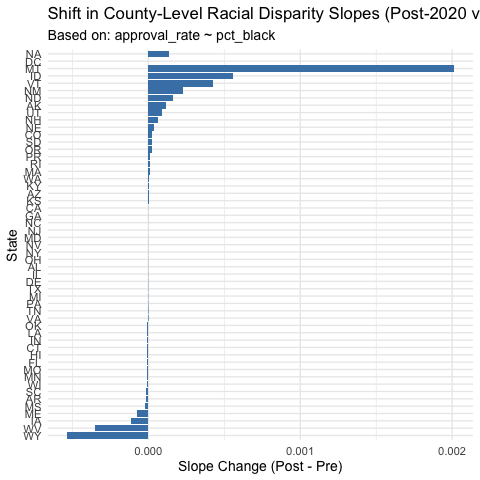

In [22]:
%%R
library(ggplot2)

ggplot(slope_change_df, aes(x = reorder(state_code, slope_change), y = slope_change)) +
  geom_col(fill = "steelblue") +
  coord_flip() +
  labs(
    title = "Shift in County-Level Racial Disparity Slopes (Post-2020 vs Pre-2020)",
    subtitle = "Based on: approval_rate ~ pct_black",
    x = "State",
    y = "Slope Change (Post - Pre)"
  ) +
  theme_minimal(base_size = 14)
